In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import pandas_market_calendars as mcal

import warnings
warnings.filterwarnings('ignore')

In [2]:
def nyse_holidays():
    nyse = mcal.get_calendar('NYSE')
    holidays = nyse.holidays()
    nyse_holidays = holidays.holidays
    
    return nyse_holidays

# shift dates if they fall on a weekend/trading holiday
def get_prev_business_date(date, holidays):
    if date.isoweekday() in set((6, 7)):
        #if date falls on a weekend, move the date back
        date -= pd.offsets.BDay(n = date.isoweekday() % 5)
    elif date in holidays:
        #if date is a NYSE trading holiday, move the date back
        date -= pd.offsets.BDay(n=1)  # get prev day
        # now if the new date is on a weekend, move it back 
        if date.isoweekday() in set((6, 7)):
            date -= pd.offsets.BDay(n = date.isoweekday() % 5)

    return date

In [3]:
#Load Price Data
wd = os.getcwd()

df = pd.read_excel(wd+'/Data/'+'WTI.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%m-%d-%Y')
df.set_index('Date', inplace=True)

In [4]:
def get_ma(df, column, freq='monthly'):
    df[df.columns[column] + '_temp'] = df[df.columns[column]]
    
    for i in range(0, len(df[df.columns[column]])-22):
        df.iloc[i, column] = np.mean(df.iloc[i:i+22, -1])
        
    drop_col_name = df.columns[column] + '_temp'
    df = df.loc[:, ~df.columns.isin([drop_col_name])]
    
    return df

In [5]:
# df = get_ma(df, 0)

In [6]:
#Load Features

xlsx_files = glob.glob(os.path.join(wd, 'Data', "*.xlsx"))
holidays = nyse_holidays()
daily_data = ['DowJones', 'SPX', 'USDEUR', 'DAX', 'NG1', 'Nikkei', 'HangSeng', 'GT10']

for file in xlsx_files:
    data_name = file.split("\\")[-1].split('.')[0]
    data_name = data_name.replace(" ", "_")
    
    if data_name == 'WTI':
        continue
        
    df_temp = pd.read_excel(file)
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    #print(data_name)
    if data_name in daily_data:
        df_temp['Date'] = df_temp['Date'].dt.strftime('%m-%d-%Y')
        df_temp.set_index('Date', inplace=True)
    else:
        df_temp['Artificial Date'] = df_temp['Date'].apply(lambda x: get_prev_business_date(x, holidays))
        df_temp['Artificial Date'] = df_temp['Artificial Date'].dt.strftime('%m-%d-%Y')
        df_temp = df_temp.drop(columns=['Date'])
        df_temp.set_index('Artificial Date', inplace=True)
    
    try:
        df[df_temp.columns[0] + '_' + data_name] = df_temp[df_temp.columns[0]]
    except ValueError:
        print(data_name, "Error")

#backfill data for other frequencies
df.fillna(method='bfill', inplace=True)
idx = list(df.index).index('12-31-2020')
df = df.iloc[idx:,:]
df_t = df.copy()

In [7]:
df_t

,PX_LAST,PX_VOLUME,PX_LAST_Canada_daily_prod,PX_LAST_Cass_Freight_Rates,PX_LAST_China_GDP,PX_LAST_DAX,PX_LAST_DowJones,PX_LAST_Europe_Inflation,PX_LAST_Europe_IndProd_exConstruction,PX_LAST_Germany_GDP,...,PX_LAST_OPEC_daily_prod,PX_LAST_Russia_GDP,PX_LAST_Russia_Industrial_Production,PX_LAST_Russia_daily_prod,PX_LAST_SPX,PX_LAST_US_GDP,PX_LAST_US_Inflation,PX_LAST_USDEUR,PX_LAST_US_daily_prod,PX_LAST_US_IndProd_Index
Date,,,,,,,,,,,,,,,,,,,,,
12-31-2020,48.52,181894.0,4643.0,1.122,6.5,13718.78,30606.48,-0.3,101.8,-3.3,...,25480.0,-1.8,3.8,9654.725,3756.07,-1.0,1.4,0.8186,11063.097,98.2854
12-30-2020,48.40,266957.0,4490.0,1.154,4.9,13718.78,30409.56,-0.3,101.8,-3.8,...,25260.0,-3.5,-1.0,9621.970,3732.04,-1.7,1.2,0.8130,11121.033,97.1609
12-29-2020,48.00,213778.0,4490.0,1.154,4.9,13761.38,30335.67,-0.3,101.8,-3.8,...,25260.0,-3.5,-1.0,9621.970,3727.04,-1.7,1.2,0.8163,11121.033,97.1609
12-28-2020,47.62,238462.0,4490.0,1.154,4.9,13790.29,30403.97,-0.3,101.8,-3.8,...,25260.0,-3.5,-1.0,9621.970,3735.36,-1.7,1.2,0.8187,11121.033,97.1609
12-24-2020,48.23,167390.0,4490.0,1.154,4.9,13587.23,30199.87,-0.3,101.8,-3.8,...,25260.0,-3.5,-1.0,9621.970,3703.06,-1.7,1.2,0.8206,11121.033,97.1609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08-01-1990,21.62,38007.0,NaN,NaN,NaN,1892.89,2899.26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,355.52,NaN,NaN,0.7566,NaN,NaN
05-01-1990,23.08,50.0,NaN,NaN,NaN,1787.87,2668.92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,332.25,NaN,NaN,0.8003,NaN,NaN
04-01-1990,23.41,2500.0,NaN,NaN,NaN,1787.87,2635.59,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,332.74,NaN,NaN,0.8175,NaN,NaN


In [8]:
def get_raw_data(df, freq = 'daily'):
    if freq == 'weekly':
        df = df.iloc[::5, :]
    
    #Add Sign and returns Data point
    df['PX_Sign'] = np.sign(df['PX_LAST'] - df['PX_LAST'].shift(-1))
    df.loc[df.PX_Sign == 0, 'PX_Sign'] = int(1)
    df['Returns'] = df['PX_LAST']/df['PX_LAST'].shift(-1) - 1
    
    return df
    

In [9]:
def plot_graph(df):
    ax = df_t[df_t.columns[0]][::-1].plot()
    ax.set_ylabel("WTI Price")
    ax.set_title('WTI Price (1990-2021)')

In [10]:
prices = ['PX_LAST']
classification = ['PX_Sign']
returns = ['Returns']

In [11]:
#Dict for frequency adjustment
cols_freq = {
    'PX_LAST':"daily",
    'PX_VOLUME':"daily",
    'PX_LAST_DowJones':"daily",
    'PX_MID_GT10':"daily",
    'PX_LAST_HangSeng':"daily",
    'PX_LAST_Nikkei':"daily",
    'PX_LAST_SPX':"daily",
    'PX_LAST_USDEUR':"daily",
    'PX_LAST_NG1':"daily",
    'PX_LAST_DAX':"daily",
    'PX_LAST_US_daily_prod':"monthly",
    'PX_LAST_Cass_Freight_Rates':"monthly",
    'PX_LAST_Canada_daily_prod':"monthly",
    'PX_LAST_Russia_daily_prod':"monthly",
    'PX_LAST_OPEC_daily_prod':"monthly",
    'PX_LAST_US_Inflation':"monthly",
    'PX_LAST_Europe_Inflation':"monthly",
    'PX_LAST_Europe_IndProd_exConstruction':"monthly",
    'PX_LAST_Russia_Industrial_Production':"monthly",
    'PX_LAST_US_IndProd_Index':"monthly",
    'PX_LAST_China_GDP':"quarterly",
    'PX_LAST_Germany_GDP':"quarterly",
    'PX_LAST_Japan_GDP':"quarterly",
    'PX_LAST_Russia_GDP':"quarterly",
    'PX_LAST_US_GDP':"quarterly",
    'PX_Sign':'daily',
    'Returns':'daily'
}

In [12]:
def daily_lag(df, column, lag):
    lag = lag+1
    if column==0:
        for i in range(1, lag):
            #creating new column here since column==0 is target
            
            df[df.columns[column] + '_t-' + str(i)] = df[df.columns[column]].shift(-i)
            cols_freq[df.columns[column]+'_t-'+str(i)] = "daily"
    else:
        for i in range(1, lag):
            #replacing old column here and renaming
            df[df.columns[column]] = df[df.columns[column]].shift(-i)
            df.rename(columns={df.columns[column]:df.columns[column]+'_t-'+str(i)}, inplace=True)
            new_col = df.columns[column]
            cols_freq[new_col] = "daily"
    
    return df


def ma(df, column, freq = "monthly"):
    if freq == "monthly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        for i in range(0, len(df[df.columns[column]])-22):
            df.iloc[i, column] = np.mean(df.iloc[i:i+22, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA22'}, inplace=True)
        cols_freq[df.columns[column]] = "monthly"
    elif freq == "quarterly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        for i in range(0, len(df[df.columns[column]])-65):
            df.iloc[i, column] = np.mean(df.iloc[i:i+65, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA65'}, inplace=True)
        cols_freq[df.columns[column]] = "quarterly"
    
    return df


def lag_data(df, column, freq = "monthly"):
    if freq == "monthly":
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-22)
        df.rename(columns={df.columns[column]:df.columns[column]+'_M'}, inplace=True)
    elif freq == "quarterly":
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-65)
        df.rename(columns={df.columns[column]:df.columns[column]+'_Q'}, inplace=True)
    elif freq == "weekly":
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-10)
        df.rename(columns={df.columns[column]:df.columns[column]+'_W'}, inplace=True)
    else:
        raise ValueError("Frequency invalid")
    
    return df

def get_lag_ma_data(df, daily_lags = 1, cols_freq=cols_freq):
    for i in range(len(df.columns)):
        column_name = df.columns[i]
        #print(column_name)
        if cols_freq[column_name] == 'daily':
            df = daily_lag(df, i, daily_lags)
        else:
            df = lag_data(df, i, cols_freq[column_name])
            df = ma(df, i, cols_freq[column_name])
            
    return df

In [13]:
def one_day_change(df, column):
    #creating new column here, will drop old column later in get_diffs
    df[df.columns[column] + '_1D_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-1)
    return df

def two_week_change(df, column):
    #creating new column here, will drop old column later in get_diffs
    df[df.columns[column] + '_2W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-10)
    return df

def one_month_change(df, column):
    #creating new column here, will drop old column later in get_diffs
    df[df.columns[column] + '_1M_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-22)
    return df

def get_diffs(df, target, cols_freq=cols_freq, drop=True):
    cols = []
    for i in range(1, len(df.columns)):
        column_name = df.columns[i]
        #collecting old columns to drop later
        cols.append(column_name)
        
        if cols_freq[column_name] == 'daily':
            df = one_day_change(df, i)
            df = two_week_change(df, i)
            df = one_month_change(df, i)
        elif cols_freq[column_name] == 'monthly':
            df = two_week_change(df, i)
            df = one_month_change(df, i)
        elif cols_freq[column_name] == 'quarterly':
            df = one_month_change(df, i)
        
    #dropping old columns
    target_lagged = df.columns[0] + '_t-1'
    cols.remove(target_lagged)
    #print(cols)
    df = df.loc[:, ~df.columns.isin(cols)]
    
    return df

In [14]:
def make_regime(df, end, start=0):
    if start==0 and end==0:
        return df
    
    if start!=0:
        st_idx = list(df.index).index(start)
    else:
        st_idx = 0
    end_idx = list(df.index).index(end)
    df_reg = df.iloc[st_idx:end_idx,:]
    return df_reg

In [ ]:
from sklearn.preprocessing import StandardScaler

def do_pca(feature_set):
    
    x = feature_set.values #returns a numpy array
    x_scaled = StandardScaler().fit_transform(x)
    feature_set = pd.DataFrame(x_scaled)
    
    n = len(feature_set)
    d = len(feature_set.columns)
    
    k = int(round(2*d/3, 0)) #no. of reduced features needed
    w0 = np.random.randn(k, d) #Y is (n x d) dimensional
    wt = w0
    I = 10 #no. of iterations for alternating minimisation
    residuals_am = np.zeros(I)

    for t in range(I):
        wt_1 = wt
        gram_w = np.matmul(wt_1, wt_1.T)
        gram_w_inv = np.linalg.inv(gram_w)
        xt = np.zeros((n,k))
        for i in range(n):
            xt[i] = np.matmul(feature_set.iloc[i].values, np.matmul(wt_1.T, gram_w_inv))

        gram_x = np.matmul(xt.T, xt)
        gram_x_inv = np.linalg.inv(gram_x)
        wt = np.zeros((k,d))
        for j in range(d):
            wt[:,j] = np.matmul(np.matmul(gram_x_inv, xt.T), feature_set.iloc[:,j])

        residuals_am[t] = np.linalg.norm(feature_set.values-np.matmul(xt, wt))
        
    return xt, k, residuals_am

In [45]:
def get_final_data(df, features, regime, target=classification, pca=False):
    if target != prices:
        features = ['PX_LAST'] + features
    
    df_trial = get_lag_ma_data(df[target + features])
    df_trial = get_diffs(df_trial, target)
    
    df_trial = df_trial.dropna()
    df_trial = df_trial[::-1]
    
    df_reg = make_regime(df_trial, end=regime[1], start=regime[0])
    
    df_target = df_reg[target]
    df_features_raw = df_reg.iloc[:, 1:]
    
    if pca:
        d = len(df_features_raw.columns)
        xt, k, res = do_pca(df_features_raw)
        df_features = pd.DataFrame(xt)
        df_features.index = df_features_raw.index
        print("PCA reduced features from {} to {}".format(d, k))
        print("Error = {}".format(res[-1]))
    else:
        df_features = df_features_raw.copy()
    
    if target == classification:
        df_target = df_target.astype(int)
    
    return df_target, df_features

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

def get_data_splits(target, features, n_splits=100, train_per=0.8):
            
    train_n = int(len(target) * train_per)   
    train_x = features[:train_n].to_numpy()            
    train_y = target[:train_n].to_numpy()    
    test_x = features[train_n:].to_numpy()    
    test_y = target[train_n:].to_numpy()

    splits = TimeSeriesSplit(n_splits=n_splits)

    split_train_x = []
    split_val_x = []
    split_train_y = []
    split_val_y = []

    for train_index, val_index in splits.split(train_x):
        split_train_x.append(train_x[train_index])
        split_train_y.append(train_y[train_index])
        split_val_x.append(train_x[val_index])
        split_val_y.append(train_y[val_index])
        
    split_data = [split_train_x, split_train_y, split_val_x, split_val_y]
    train_data = [train_x, train_y]
    test_data = [test_x, test_y]
    
    return split_data, train_data, test_data

### Classification Models

In [18]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def svc_hinge(split_data, iters=1000):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    lambdas = np.arange(0.001, 0.101, 0.02)
    Hloss = []
    Rh = []
    count = 0
    
    for lam in lambdas:
        scaler = RobustScaler()
        clf = svm.LinearSVC(penalty='l2', loss='hinge', fit_intercept=True,
                            C=(1/lam), max_iter=iters, random_state=42)
        acc = []
        
        for i in range(len(split_train_x)):
            scaled_fit_train = scaler.fit(split_train_x[i])
            split_train_x[i] = scaled_fit_train.transform(split_train_x[i])
            split_val_x[i] = scaled_fit_train.transform(split_val_x[i])
            
            model = clf.fit(split_train_x[i], split_train_y[i].reshape(-1,1))
            pred = model.predict(split_val_x[i])
            acc.append(np.mean(pred != split_val_y[i]))
            count+=1
            #print(count)
        Hloss.append(np.mean(acc))
        Rh.append(lam)
    l_star = Rh[np.argmin(Hloss)]
    print('Lambda* = {}'.format(l_star))
    print('SVM Validation Error Rate = {}'.format(Hloss[np.argmin(Hloss)]))
    return Hloss, Rh, l_star

def svc_hinge_test(train_data, test_data, l_star, iters=10000):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    scaler = RobustScaler()
    scaled_fit_train = scaler.fit(train_x)
    
    train_x_std = scaled_fit_train.transform(train_x)
    test_x_std = scaled_fit_train.transform(test_x)
    
    
    model = svm.LinearSVC(penalty='l2', loss='hinge', fit_intercept=True,
                            C=(1/l_star), max_iter=iters, random_state=42)
    
    train_y = train_y.reshape(-1,1)
    model.fit(train_x_std, train_y)
    pred = model.predict(test_x_std)
    mse = np.mean(pred!=test_y)
    
    return pred, mse

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def decision_tree(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    maxnodes = np.arange(3, 18, 1)
    maxnodes_misclas = []
    
    for maxnode in maxnodes:
        misclas = []
        
        for i in range(len(split_train_x)):
            model = tree.DecisionTreeClassifier(random_state=42, max_leaf_nodes = maxnode)
            model = model.fit(split_train_x[i], split_train_y[i])
            yhat = model.predict(split_val_x[i])
            misclas.append(np.mean(yhat!=split_val_y[i]))

        maxnodes_misclas.append(np.mean(misclas))
    
    best_nodes = maxnodes[np.argmin(maxnodes_misclas)]
    print('Best Max Nodes = {}'.format(best_nodes))
    print('Decision Tree Validation Error Rate = {}'.format(maxnodes_misclas[np.argmin(maxnodes_misclas)]))
    
    return maxnodes_misclas, best_nodes

def decision_tree_test(train_data, test_data, maxnodes):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    tr_model = tree.DecisionTreeClassifier(random_state=2, max_leaf_nodes = maxnodes)
    tr_model = tr_model.fit(train_x, train_y)
    pred = tr_model.predict(test_x)
    error = np.mean(pred!=test_y)
    
    return pred, error



In [20]:
from sklearn.linear_model import LogisticRegression

def logistic(split_data, iters=1000):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    lambdas = np.arange(0.01, 1.01, 0.20)
    Lloss = []
    Rl = []
    count = 0
    
    for lam in lambdas:
        scaler = RobustScaler()
        clf = LogisticRegression(penalty='l2', C=(1/lam), max_iter=iters, random_state=42,
                            fit_intercept=True)
        acc = []
        
        for i in range(len(split_train_x)):
            scaled_fit_train = scaler.fit(split_train_x[i])
            split_train_x[i] = scaled_fit_train.transform(split_train_x[i])
            split_val_x[i] = scaled_fit_train.transform(split_val_x[i])
            
            model = clf.fit(split_train_x[i], split_train_y[i].reshape(-1,1))
            pred = model.predict(split_val_x[i])
            acc.append(np.mean(pred != split_val_y[i]))
            count+=1
            #print(count)
        Lloss.append(np.mean(acc))
        Rl.append(lam)
    l_star = Rl[np.argmin(Lloss)]
    print('Lambda* = {}'.format(l_star))
    print('Logistic Validation Error Rate = {}'.format(Lloss[np.argmin(Lloss)]))
    return Lloss, Rl, l_star

def logistic_test(train_data, test_data, l_star, iters=1000):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    scaler = RobustScaler()
    scaled_fit_train = scaler.fit(train_x)
    
    train_x_std = scaled_fit_train.transform(train_x)
    test_x_std = scaled_fit_train.transform(test_x)
    
    model = LogisticRegression(penalty='l2', C=(1/l_star), max_iter=iters, random_state=42, 
                             fit_intercept=True)
    
    train_y = train_y.reshape(-1,1)
    model.fit(train_x_std, train_y)
    pred = model.predict(test_x_std)
    mse = np.mean(pred!=test_y)
    
    return pred, mse

### Regression Models

In [21]:
def lasso(split_data, alphas=np.arange(0.05, 1.01, 0.05)):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alpha_rmse = []
    
    for alpha in alphas:
        transformer = RobustScaler
        model = linear_model.Lasso(alpha=alpha)
        rmse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            rmse.append(np.sqrt(np.mean((yhat-split_val_y[i])**2)))
        alpha_rmse.append(np.mean(rmse))
    a_star = alphas[np.argmin(alpha_rmse)]
    print('Lasso Alpha* = {}'.format(a_star))
    print('Lasso Validation RMSE = {}'.format(alpha_rmse[np.argmin(alpha_rmse)]))
    return alpha_rmse, a_star

def lasso_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.Lasso(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    rmse = np.mean((pred-test_y)**2)**0.5
    
    return pred, rmse

In [65]:
def huber(split_data, alphas=np.arange(0.05, 1.01, 0.05)):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alpha_rmse = []
    
    for alpha in alphas:
#         print('alpha=', alpha)
        transformer = RobustScaler
        model = linear_model.HuberRegressor(alpha=alpha)
        rmse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            rmse.append(np.mean((yhat-split_val_y[i])**2)**0.5)
        alpha_rmse.append(np.mean(rmse))
    a_star = alphas[np.argmin(alpha_rmse)]
    print('Huber Alpha* = {}'.format(a_star))
    print('Huber Validation RMSE = {}'.format(alpha_rmse[np.argmin(alpha_rmse)]))
    return alpha_rmse, a_star

def huber_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.HuberRegressor(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    rmse = np.mean((pred-test_y)**2)**0.5
    
    return pred, rmse

In [23]:
from sklearn.ensemble import RandomForestRegressor

def RF_regressor(split_data, estimators = np.arange(950, 1000, 10)):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimator_rmse = []
    
    for estimator in estimators:
        print('n_est=', estimator)
        model = RandomForestRegressor(n_estimators=estimator)
#         rmse = []
        model.fit(split_train_x[-1], split_train_y[-1])
        yhat = model.predict(split_val_x[-1])
#         rmse.append(np.mean((yhat-split_val_y[-1])**2)**0.5)
#         estimator_rmse.append(np.mean(rmse))
        estimator_rmse.append(np.mean((yhat-split_val_y[-1])**2)**0.5)
    best_est = estimators[np.argmin(estimator_rmse)]
    print('Random Forest Efficient Estimator = {}'.format(best_est))
    print('Random Forest Validation RMSE = {}'.format(estimator_rmse[np.argmin(estimator_rmse)]))
    return estimator_rmse, best_est

def RF_regressor_test(train_data, test_data, best_est):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = RandomForestRegressor(n_estimators=best_est)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    rmse = np.mean((pred-test_y)**2)**0.5
    
    return pred, rmse

### Turn into code:

In [24]:
import xgboost as xgb

def XGBoost(split_data, estimators = np.arange(10, 1000, 10)):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimator_rmse = []
    
    for estimator in estimators:
        print('est=',estimator)
        transformer = RobustScaler
        model = xgb.XGBRegressor(n_estimators=estimator, subsample=1.0)
        rmse = []
        
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            rmse.append(np.mean((yhat-split_val_y[i])**2)**0.5)
        estimator_rmse.append(np.mean(rmse))
    best_est = estimators[np.argmin(estimator_rmse)]
    print('Efficient Estimator = {}'.format(best_est))
    return estimator_rmse, best_est

def XGBoost_test(train_data, test_data, best_est):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = xgb.XGBRegressor(n_estimators=best_est, subsample=1.0)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    rmse = np.mean((pred-test_y)**2)**0.5
    
    return pred, rmse

In [25]:
def classification_models(features, regime_period, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=classification,
                                            pca=pca)
    
    split_data, train_data, test_data = get_data_splits(df_target, df_features)
    
    Hloss, Rh, hinge_lambda = svc_hinge(split_data)
    hinge_yhat, hinge_error = svc_hinge_test(train_data, test_data, hinge_lambda)
    print("SVM Test error rate = ", hinge_error, '\n')
    
    Lloss, Rl, log_lambda = logistic(split_data)
    log_yhat, log_error = logistic_test(train_data, test_data, log_lambda)
    print("Logistic Test error rate = ", log_error, '\n')
    
    trees_maxnode_misclas, trees_max_nodes = decision_tree(split_data)
    trees_yhat, trees_error = decision_tree_test(train_data, test_data, trees_max_nodes)
    print("Decision Trees Test error rate = ", trees_error, '\n')
    
    yhats = [hinge_yhat, log_yhat, trees_yhat]
    errors = [hinge_error, log_error, trees_error]
    
    return yhats, errors

In [26]:
def plot_graph(yhat, test_y):
    plt.plot(yhat, label='pred')
    plt.plot(test_y, label='true')
    plt.legend()
    plt.show()

In [27]:
def regression_models(features, regime_period, target=prices, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=target,
                                            pca=pca)
    
    split_data, train_data, test_data = get_data_splits(df_target, df_features)
    test_x = test_data[0]
    test_y = test_data[1]
    
    lasso_mse, lasso_alpha = lasso(split_data)
    lasso_pred, lasso_mse = lasso_test(train_data, test_data, lasso_alpha)
    lasso_rmse = np.sqrt(lasso_mse)
    print("Lasso RMSE = ", lasso_mse)
    plot_graph(lasso_pred, test_y)
    
    huber_mse, huber_alpha = huber(split_data)
    huber_pred, huber_mse = huber_test(train_data, test_data, huber_alpha)
    huber_rmse = np.sqrt(huber_mse)
    print("Huber RMSE = ", huber_rmse)
    plot_graph(huber_pred, test_y)
    
    RF_mse, RF_best_est = RF_regressor(split_data)
    rf_pred, rf_mse = RF_regressor_test(train_data, test_data, RF_best_est)
    rf_rmse = np.sqrt(rf_mse)
    print("RandomForest RMSE = ", rf_rmse)
    plot_graph(rf_pred, test_y)
    
    pred = [lasso_pred, huber_pred, rf_pred]
    rmse = [lasso_rmse, huber_rmse, rf_rmse]
    
    return pred, rmse

In [28]:
def meta_ready(features, regime_period, target=prices, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=target,
                                            pca=pca)
    
    return df_target, df_features

In [29]:
# Feature Categories by Type
fin_indices = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10',
           'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX',
           'PX_LAST_USDEUR']
nat_gas = ['PX_LAST_NG1']
gdp = ['PX_LAST_China_GDP', 'PX_LAST_Germany_GDP', 'PX_LAST_Japan_GDP',
       'PX_LAST_Russia_GDP', 'PX_LAST_US_GDP']
oil_prod = ['PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod',
            'PX_LAST_OPEC_daily_prod', 'PX_LAST_US_daily_prod']
freight = ['PX_LAST_Cass_Freight_Rates']
inflation = ['PX_LAST_US_Inflation', 'PX_LAST_Europe_Inflation']
ind_prod = ['PX_LAST_Europe_IndProd_exConstruction', 
            'PX_LAST_Russia_Industrial_Production',
            'PX_LAST_US_IndProd_Index']

In [30]:
# Feature Categories by Date Range
feat_1992 = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10', 
             'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX', 
             'PX_LAST_USDEUR', 'PX_LAST_NG1', 'PX_LAST_China_GDP', 
             'PX_LAST_Germany_GDP', 'PX_LAST_US_GDP', 'PX_LAST_US_daily_prod', 
             'PX_LAST_Cass_Freight_Rates', 'PX_LAST_US_Inflation', 
             'PX_LAST_Europe_IndProd_exConstruction', 'PX_LAST_US_IndProd_Index']
feat_1996 = feat_1992 + ['PX_LAST_Japan_GDP', 'PX_LAST_Russia_GDP',
                         'PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod']
feat_2000 = feat_1996 + ['PX_LAST_OPEC_daily_prod', 'PX_LAST_Europe_Inflation']
feat_2002 = feat_2000 + ['PX_LAST_Russia_Industrial_Production']

In [31]:
reg_92_99 = [[0, '12-30-1999'], [0, '12-30-1999']]
reg_00_06 = [['04-03-2000', '12-29-2006'], ['12-14-2000', '12-28-2006']]
reg_07_12 = [['01-02-2007', '12-31-2012'], ['01-05-2007', '12-24-2012']]
reg_13_20 = [['01-02-2013', '12-31-2020'], ['01-02-2013', '12-31-2020']]
no_regime = [[0, 0], [0, 0]]

### Implementation

In [56]:
df_m = get_raw_data(df_t)
features = feat_2002
target=prices
regime = no_regime
freq='daily'
pca=True

df_target, df_features = meta_ready(features, regime, target, freq, pca)



PCA reduced features from 53 to 18
Error = 216.99556194431779


In [57]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Date,,,,,,,,,,,,,,,,,,
05-04-2002,0.079620,0.047531,-0.005218,-0.107596,0.010701,-0.133185,-0.016240,0.004205,-0.046753,-0.204933,-0.102936,-0.080686,-0.016747,0.107538,-0.122052,-0.029406,-0.035633,-0.000443
08-04-2002,0.039583,0.088285,-0.056860,-0.055260,0.093237,-0.055886,-0.060660,-0.051115,-0.026843,-0.185864,-0.134655,-0.068525,-0.054423,0.130947,-0.161728,0.040323,-0.077137,0.023882
09-04-2002,0.040993,0.094166,-0.050365,-0.059763,0.107422,-0.056552,-0.101618,-0.062250,-0.039744,-0.178943,-0.132964,-0.065114,-0.039534,0.120560,-0.189036,0.056893,-0.079055,0.050034
10-04-2002,0.220626,0.069202,0.230002,-0.501270,-0.051574,-0.564836,0.118434,0.553629,-0.511118,-0.118754,0.405079,-0.027134,-0.120669,-0.104220,-0.059734,0.100928,-0.193073,-0.235767
11-04-2002,0.004191,0.300072,0.291711,-0.241306,-0.104369,-0.369984,-0.042908,0.181985,-0.222178,-0.274420,0.352787,-0.013818,0.105129,0.111808,-0.208240,-0.167447,-0.230368,-0.389673


In [58]:
df_target.head()

,PX_LAST
Date,
05-04-2002,26.21
08-04-2002,26.54
09-04-2002,25.82
10-04-2002,26.13
11-04-2002,24.99


In [59]:
split_data, train_data, test_data = get_data_splits(df_target, df_features, n_splits=100, train_per=0.75)

#### Lasso regression with time series CV to find lambda

In [60]:
alpha_rmse, a_star_lasso = lasso(split_data, alphas=np.arange(0.01, 0.5, 0.02))

Lasso Alpha* = 0.01
Lasso Validation RMSE = 16.58762530832755


In [61]:
pred_lasso, rmse = lasso_test(train_data, test_data, alpha=a_star_lasso)

In [62]:
rmse

16.500068924551247

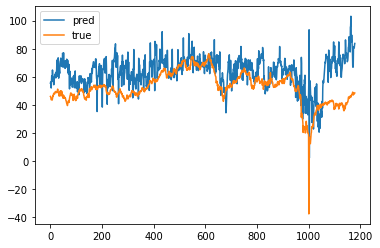

In [63]:
plt.plot(pred_lasso, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()
# plt.xlim(1000, 1050)
# plt.ylim(0,40)

#### Huber regression with time series CV to find lambda

In [66]:
alpha_rmse, a_star_huber = huber(split_data, alphas=np.arange(0.01, 0.5, 0.02))

Huber Alpha* = 0.01
Huber Validation RMSE = 8.073377880275094


In [67]:
pred_huber, rmse = huber_test(train_data, test_data, alpha=a_star_huber)

In [68]:
rmse

14.753208597506621

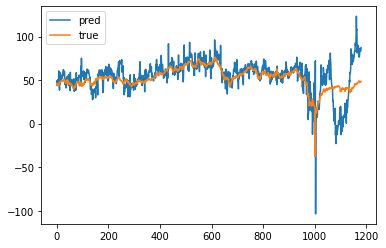

In [69]:
plt.plot(pred_huber, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()
# plt.xlim(900, 1100)
# plt.ylim(-40,60)

#### Random Forest regression with time series CV to find no of base esimators

In [70]:
estimator_rmse, best_est_rf = RF_regressor(split_data, estimators = np.arange(50, 1001, 50))

n_est= 50
n_est= 100
n_est= 150
n_est= 200
n_est= 250
n_est= 300
n_est= 350
n_est= 400
n_est= 450
n_est= 500
n_est= 550
n_est= 600
n_est= 650
n_est= 700
n_est= 750
n_est= 800
n_est= 850
n_est= 900
n_est= 950
n_est= 1000
Random Forest Efficient Estimator = 50
Random Forest Validation RMSE = 14.416238078579504


In [71]:
pred, rmse = RF_regressor_test(train_data, test_data, best_est_rf)

In [72]:
rmse

20.112566648471013

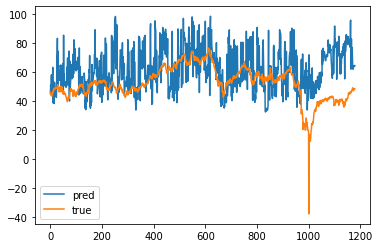

In [73]:
plt.plot(pred, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()

#### XGBoost with time series CV to find no of base esimators

In [74]:
estimator_rmse, best_est_xg = XGBoost(split_data, estimators = np.arange(50, 1001, 50))

est= 50
est= 100
est= 150
est= 200
est= 250
est= 300
est= 350
est= 400
est= 450
est= 500
est= 550
est= 600
est= 650
est= 700
est= 750


KeyboardInterrupt: 

In [ ]:
pred, rmse = XGBoost_test(train_data, test_data, best_est_xg)

In [ ]:
rmse

In [ ]:
plt.plot(pred, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()

### Stacking of all the regressors

In [ ]:
from sklearn.ensemble import StackingRegressor

level0 = list()
level0.append(('xgb', TransformedTargetRegressor(regressor=xgb.XGBRegressor(n_estimators=best_est_xg, subsample=1.0)
                                                 , transformer=RobustScaler())))
level0.append(('rf', TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=best_est_rf), transformer=RobustScaler())))
level0.append(('huber', TransformedTargetRegressor(regressor=linear_model.HuberRegressor(alpha=a_star_huber), transformer=RobustScaler())))
level0.append(('lasso', TransformedTargetRegressor(regressor=linear_model.Lasso(alpha=a_star_lasso), transformer=RobustScaler())))
level1 = LinearRegression()

In [ ]:
stack_model = StackingRegressor(estimators=level0, final_estimator=level1)
stack_model.fit(train_data[0], train_data[1])
stack_pred = stack_model.predict(test_data[0])
stack_rmse = np.mean((stack_pred - train_data[1])**2)**0.5

In [ ]:
plt.plot(stack_pred, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()

In [ ]:
stack_rmse

#### Classify data and predict 

In [ ]:
split_n = int(len(train_data[0])*0.6)

r_train_X = train_data[0][:split_n]
r_train_y = train_data[1][:split_n]

c_train_X = train_data[0][split_n:]
c_train_y = train_data[1][split_n:]


In [ ]:
models_meta = [0]*4

In [ ]:
lasso = linear_model.Lasso(alpha=a_star_lasso)
models_meta[0] = TransformedTargetRegressor(regressor=lasso, transformer=RobustScaler())
models_meta[0].fit(r_train_X, r_train_y)

In [ ]:
huber = linear_model.HuberRegressor(alpha=a_star_huber)
models_meta[1] = TransformedTargetRegressor(regressor=huber, transformer=RobustScaler())
models_meta[1].fit(r_train_X, r_train_y)

In [ ]:
models_meta[2] = RandomForestRegressor(n_estimators=best_est_rf)
models_meta[2].fit(r_train_X, r_train_y)

In [ ]:
xgb_reg = xgb.XGBRegressor(n_estimators=best_est_xg, subsample=1.0)
models_meta[3] = TransformedTargetRegressor(regressor=xgb_reg, transformer=RobustScaler())
models_meta[3].fit(r_train_X, r_train_y)

In [ ]:
model_num = []
for i, x in enumerate(c_train_X):
    err = []
    for model in models_meta:
#         print(model)
        yhat = model.predict(x.reshape(1,-1))
        err.append((yhat-c_train_y[i])**2)
    model_num.append((np.argmin(err)))


In [ ]:
for i in range(len(models_meta)):
    print('Count of ', i, ' is ', model_num.count(i))

In [ ]:
model_label = np.array(model_num)

In [ ]:
split = int(0.75*len(c_train_X))
t_train_X = c_train_X[:split]
t_train_y = model_label[:split]
t_val_X = c_train_X[split:]
t_val_y = model_label[split:]

In [ ]:
depths = np.arange(2, 10, 1)
scores = []
for depth in depths:
    dtree_model = DecisionTreeClassifier(max_depth = depth).fit(t_train_X, t_train_y)
    dtree_score = dtree_model.score(t_val_X, t_val_y)
    scores.append(dtree_score)
    
best_depth = depths[np.argmax(scores)]
print('Best depth: ', best_depth)

In [ ]:
scores

In [ ]:
dtree_final = DecisionTreeClassifier(max_depth=best_depth).fit(c_train_X, model_label)
model_pred = dtree_final.predict(test_data[0])

In [ ]:
meta_preds = []
for i, x in enumerate(test_data[0]):
    pred = models_meta[model_pred[i]].predict(x.reshape(1,-1))
    meta_preds.append(pred)


In [ ]:
meta_mse = np.mean((meta_preds-test_data[1])**2)**0.5
meta_mse

In [ ]:
plt.plot(meta_preds, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()
#plt.xlim(800,810)
#plt.ylim(52,58)

In [ ]:
err[-1]**0.5